In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import pickle
import re

df = pd.read_csv(r'../preprocessed_data/예술의 전당/예술의전당_preprocessed.csv', index_col = 0)
display(df)

,공연코드,공연회차,소요시간,장르명,세부장르명,출연진내용,제작진내용,기획제작사명,관람연령,아동공연 여부,...,공연시작요일,공연시작시분,공연기간,공휴일여부,좌석등급개수,평균티켓가격,좌석점유율,코로나표준점수,검색량,출연횟수
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
SE000201,PF372853,1,110,서양음악(클래식),기악,"김주원, 쾅 하오 후앙",NaN,(주)마스트미디어(주최),만 7세 이상,N,...,Tuesday,1200,1,0,1,30000.0,0.460452,0.0,30,11
SE000201,PF360668,1,100,서양음악(클래식),기악,"최유진, 이재완",NaN,예인예술기획(주최),만 7세 이상,N,...,Wednesday,1200,1,0,1,20000.0,0.968927,0.0,0,10
SE000201,PF372854,1,100,서양음악(클래식),기악,김민욱,NaN,가온클래식(주최),만 7세 이상,N,...,Thursday,1200,1,0,1,20000.0,0.742938,0.0,0,1
SE000201,PF360799,1,80,서양음악(클래식),기악,"김경희, 신미정, 장혜리, 안동호",NaN,세광아트(세광음악출판사)(주관),만 7세 이상,N,...,Friday,1200,1,0,1,30000.0,0.946541,0.0,220,10
SE000201,PF372069,1,100,서양음악(클래식),기악,나윤아,NaN,마에스트로 컴퍼니(주최),만 7세 이상,N,...,Saturday,1200,1,0,1,10000.0,0.593525,0.0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE000201,PF424244,1,90,서양음악(클래식),기악,"유의정, 김정현, 윤효린",NaN,지클레프(주최),만 7세 이상,N,...,Wednesday,1170,1,0,1,20000.0,0.946328,0.0,0,10
SE000101,PF426471,1,90,서양음악(클래식),기악,이주용,NaN,NaN,만 7세 이상,N,...,Thursday,1170,1,0,1,30000.0,0.728261,0.0,0,19
SE000201,PF425379,1,90,서양음악(클래식),기악,"김길우, 정태민",NaN,지클레프(주최),만 7세 이상,N,...,Friday,1170,1,0,1,20000.0,0.951977,0.0,0,2


In [3]:
df.drop(['공연회차','오픈런 여부','단독판매여부','제작진내용', '공연기간', '출연진내용'], axis = 1, inplace = True)

In [4]:
df.replace('만 7세 이상예술의전당','만 7세 이상', inplace = True)

#관람연령 결측치는 최빈값으로 대체
df['관람연령'] = df['관람연령'].fillna('만 7세 이상')

#관람연령은 연령순대로 labelencoding
age_dict = {'전체 관람가':0, '36개월 이상':1, '48개월 이상':2, '만 5세 이상':3, '만 7세 이상':4, '만 8세 이상':5}
df['관람연령'] = df['관람연령'].map(age_dict)

#기획제작사명 괄호 제거 및 리스트화
df['기획제작사명_전처리'] = df['기획제작사명'].apply(lambda x: ['Unknown'] if pd.isna(x) else re.sub(r'\([^)]*\)', '', x.replace(" ", "")).split(','))

df.reset_index(drop = True, inplace = True)

In [6]:
#아동공연 여부, 축제 여부, 내한공연 여부를 이진값으로 변환
ny_dict = {'N':0 , 'Y':1}
df['아동공연 여부'] = df['아동공연 여부'].map(ny_dict)
df['축제 여부'] = df['축제 여부'].map(ny_dict)
df['내한공연 여부'] = df['내한공연 여부'].map(ny_dict)

In [7]:
#장르명 열과 세부장르명 열은 통합
df['장르_세부'] = df['장르명']+'_'+df['세부장르명']
df['장르_세부'].unique()
df.drop(['장르명','세부장르명','기획제작사명'], axis = 1, inplace = True)

In [8]:
#공연시작요일 onehotencoding
oe = OneHotEncoder()
one_hot_df = oe.fit_transform(df['공연시작요일'].values.reshape(-1,1)).toarray()
one_hot_df = pd.DataFrame(one_hot_df, columns = ['dayofweek_fri','dayofweek_sat','dayofweek_sun','dayofweek_thu','dayofweek_tue', 'dayofweek_wed'])
print(one_hot_df.shape)

(990, 6)


In [9]:
df = pd.concat([df, one_hot_df], axis = 1)

In [11]:
X = df.drop(['공연코드', '좌석점유율'], axis = 1)
y = df['좌석점유율']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(792, 24)
(198, 24)
(792,)
(198,)


In [12]:
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)

In [13]:
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

In [14]:
#장르 onehotencoding
oe2 = OneHotEncoder(handle_unknown = 'ignore') 
oe2.fit(X_train['장르_세부'].values.reshape(-1,1))
one_hot_trn =oe2.transform(X_train['장르_세부'].values.reshape(-1,1)).toarray()
one_hot_trn = pd.DataFrame(one_hot_trn, columns = oe2.categories_[0])
print(one_hot_trn.shape)

(792, 5)


In [15]:
one_hot_tes = oe2.transform(X_test['장르_세부'].values.reshape(-1,1)).toarray()
one_hot_tes = pd.DataFrame(one_hot_tes, columns = oe2.categories_[0])
print(one_hot_tes.shape)

(198, 5)


In [16]:
#기획제작사명 onehotencoding
mlb = MultiLabelBinarizer()
mlb.fit(X_train['기획제작사명_전처리'])
mlb_trn = mlb.transform(X_train['기획제작사명_전처리'])
mlb_trn = pd.DataFrame(mlb_trn, columns = mlb.classes_)
print(mlb_trn.shape)

(792, 133)


In [18]:
mlb_tes = mlb.transform(X_test['기획제작사명_전처리'])
mlb_tes = pd.DataFrame(mlb_tes, columns = mlb.classes_)
print(mlb_tes.shape)

(198, 133)


C:\Users\vmffl\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:895: UserWarning: unknown class(es) ['바로크와현대가곡연구회', '서울예술가곡연구회', '서울플루트트리오', '성우회', '세종목관챔버앙상블', '스테이지원', '아트앤아티스트', '영미성악연구회', '음악오늘', '콜레기움보칼레서울', '플루트아트센터', '피아노앙상블LesSix', '한다우리예술기획'] will be ignored
  warnings.warn(


In [19]:
X_train = pd.concat([X_train, one_hot_trn, mlb_trn], axis = 1)
X_test = pd.concat([X_test, one_hot_tes, mlb_tes], axis = 1)

In [20]:
X_train.drop(['공연시작요일','기획제작사명_전처리','장르_세부'], axis = 1, inplace = True)
X_test.drop(['공연시작요일','기획제작사명_전처리','장르_세부'], axis = 1, inplace = True)

### RandomForestRegressor 

In [ ]:
rf = RandomForestRegressor(n_estimators = 100, max_features = 1.0,  random_state = 40, criterion = 'friedman_mse')
rf.fit(X_train, y_train)
trn_pred = rf.predict(X_train)
tes_pred = rf.predict(X_test)

In [23]:
print(mean_squared_error(y_train, trn_pred))
print(np.sqrt(mean_squared_error(y_train, trn_pred)))
print(mean_absolute_error(y_train, trn_pred))

0.0020422104408017003
0.04519082252849244
0.026417340805773477


In [21]:
print(mean_squared_error(y_test, tes_pred))
print(np.sqrt(mean_squared_error(y_test, tes_pred)))
print(mean_absolute_error(y_test, tes_pred))

0.011864472983944508
0.1089241616168998
0.06882673025220719


### GBM 

In [26]:
gbm = GradientBoostingRegressor(n_estimators = 300, learning_rate = 0.14, loss = 'huber',random_state=40)
gbm.fit(X_train, y_train)
trn_pred2 = gbm.predict(X_train)
tes_pred2 = gbm.predict(X_test)

In [25]:
print(mean_squared_error(y_train, trn_pred2))
print(np.sqrt(mean_squared_error(y_train, trn_pred2)))
print(mean_absolute_error(y_train, trn_pred2))

0.005387061727321866
0.07339660569346423
0.03751749117159435


In [23]:
print(mean_squared_error(y_test, tes_pred2))
print(np.sqrt(mean_squared_error(y_test, tes_pred2)))
print(mean_absolute_error(y_test, tes_pred2))

0.010626383081319406
0.10308434935197199
0.06066211451058694


In [68]:
font_list = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
[matplotlib.font_manager.FontProperties(fname=font).get_name() for font in font_list if 'Nanum' in font]

['NanumSquareRoundOTF',
 'NanumSquare Neo Regular',
 'NanumSquare Neo ExtraBold',
 'NanumSquareOTF',
 'NanumSquareOTF_ac',
 'NanumSquareRoundOTF',
 'NanumSquareOTF',
 'NanumSquare Neo Bold',
 'NanumSquare Neo Heavy',
 'NanumSquareRoundOTF',
 'NanumSquareOTF_ac',
 'NanumSquareOTF_ac',
 'NanumSquareRoundOTF',
 'NanumSquareOTF',
 'NanumSquareOTF',
 'NanumGothic',
 'NanumSquare Neo Light',
 'NanumSquareOTF_ac']

In [69]:
plt.rcParams['font.family'] = 'Malgun Gothic'

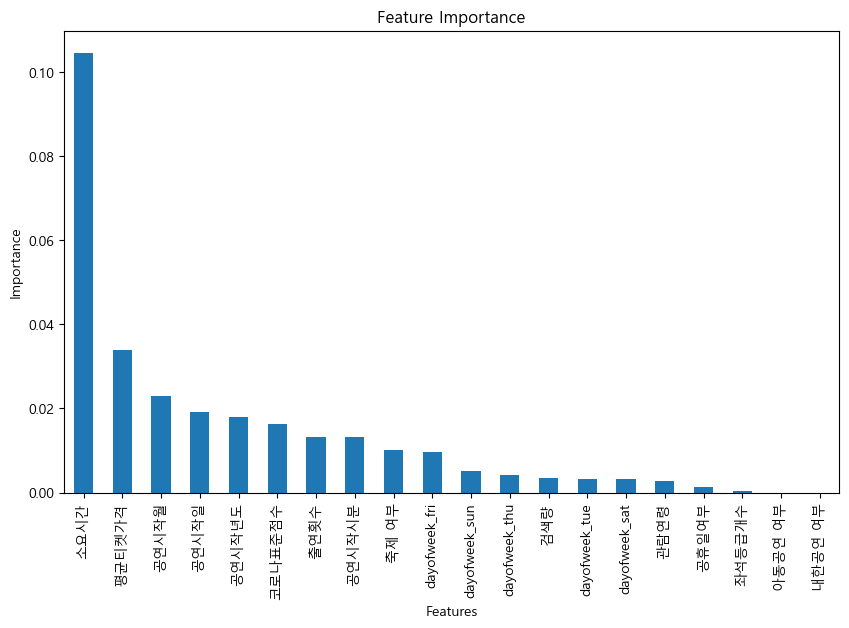

In [70]:
# imp를 활용하여 Series 생성
imp = gbm_all.feature_importances_[:20]
forest_importances = pd.Series(imp, index=X_train.columns[:20])

# 중요도 값을 기준으로 내림차순으로 정렬
forest_importances_sorted = forest_importances.sort_values(ascending=False)
#print(forest_importances_sorted.index[:20])


plt.figure(figsize=(10, 6))
forest_importances_sorted.plot(kind='bar')
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()


In [ ]:
y_data = pd.concat([y_train, y_test])
y_data.reset_index(drop = True, inplace = True)

In [ ]:
X_data = pd.concat([X_train, X_test])
X_data.reset_index(drop = True, inplace = True)

In [63]:
gbm_all = GradientBoostingRegressor(n_estimators = 300, learning_rate = 0.14, loss = 'huber',random_state=40)
gbm_all.fit(X_data, y_data)
fin_pred = gbm_all.predict(X_data)

In [71]:
filename = '../model/gbm_fin_model_sac.sav'
pickle.dump(gbm_all, open(filename, 'wb'))

In [74]:
X_data['좌석점유율'] = y_data

In [75]:
X_data.to_csv('../preprocessed_data/예술의 전당/모델학습및테스트데이터_최종.csv')

### XGBoost

In [29]:
xgb_model = XGBRegressor(learning_rate=0.1, n_estimators=500, random_state = 40)
xgb_model.fit(X_train, y_train)
trn_pred3 = xgb_model.predict(X_train)
tes_pred3 = xgb_model.predict(X_test)

In [27]:
print(mean_squared_error(y_train, trn_pred3))
print(mean_absolute_error(y_train, trn_pred3))
print(mean_absolute_percentage_error(y_train, trn_pred3))

0.0009296469385996107
0.020601443957313396
0.02577349202983109


In [25]:
print(mean_squared_error(y_test, tes_pred3))
print(np.sqrt(mean_squared_error(y_test, tes_pred3)))
print(mean_absolute_error(y_test, tes_pred3))

0.0129753570709175
0.1139094248555294
0.07028013654808823
